[link text](https://)# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [5]:
## Problem Definition

'''
For a used car dealership, our analysis focuses on identifying the key factors that drive vehicle resale prices.
By examining attributes such as age, mileage, manufacturer, condition etc.,, we use data-driven modeling to
reveal which features most impact pricing. These insights will help the dealership for inventory management,
set competitive prices, and target the vehicles consumers value most.
'''

'\nFor a used car dealership, our analysis focuses on identifying the key factors that drive vehicle resale prices. \nBy examining attributes such as age, mileage, manufacturer, condition etc.,, we use data-driven modeling to \nreveal which features most impact pricing. These insights will help the dealership for inventory management, \nset competitive prices, and target the vehicles consumers value most.\n'

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and **identify** any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [6]:
# First find how much data are we dealing with and what are the features that could potentially influence the "Target Variable" (Price)
import pandas as pd

# Load the dataset
df = pd.read_csv("data/vehicles.csv")

# Shape (rows, columns)
print("(Sample, features) = ", df.shape)

# Column names
print("\nKey Predictors:")
for c in df.columns.tolist():
    print("** ", c)

# Optional: quick look at first 3 rows
print("\nHead (Sample rows):")
print(df.head(3).to_string(index=False))

# Shows that we are dealing with ~ 400K raw samples with around 17 features (excluding Price)


#Upon staring at the Key Predictors - most influcing key features are
# Year
# Odometer
# model
# condition
# manufacturer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(Sample, features) =  (426880, 18)

Key Predictors:
**  id
**  region
**  price
**  year
**  manufacturer
**  model
**  condition
**  cylinders
**  fuel
**  odometer
**  title_status
**  transmission
**  VIN
**  drive
**  size
**  type
**  paint_color
**  state

Head (Sample rows):
        id       region  price  year manufacturer model condition cylinders fuel  odometer title_status transmission VIN drive size type paint_color state
7222695916     prescott   6000   NaN          NaN   NaN       NaN       NaN  NaN       NaN          NaN          NaN NaN   NaN  NaN  NaN         NaN    az
7218891961 fayetteville  11900   NaN          NaN   NaN       NaN       NaN  NaN       NaN          NaN          NaN NaN   NaN  NaN  NaN         NaN    ar
7221797935 florida keys  21000   NaN          NaN   NaN       NaN       NaN  NaN       NaN          NaN          NaN NaN   

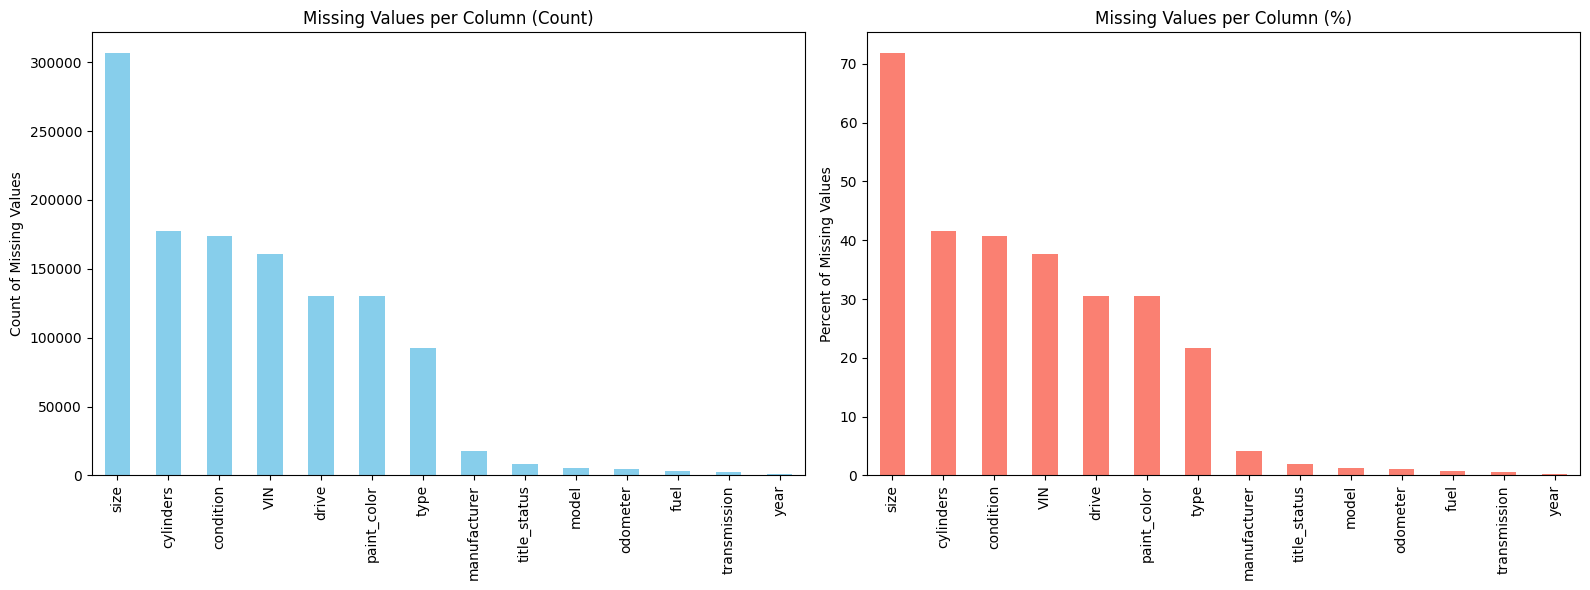

In [7]:
## Next step is to see the missing values to get the quality of the data (Data Understanding - phase of the CRISP-DM process)
import matplotlib.pyplot as plt

missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

missing_summary = missing[missing > 0].sort_values(ascending=False)
missing_percent_summary = missing_percent[missing_percent > 0].sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

missing_summary.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Missing Values per Column (Count)")
axes[0].set_ylabel("Count of Missing Values")
axes[0].tick_params(axis='x', rotation=90)

missing_percent_summary.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("Missing Values per Column (%)")
axes[1].set_ylabel("Percent of Missing Values")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [8]:
## Next steps is to clean up the data and remove the outliers from these key predictors and features
import pandas as pd

def remove_outliers_iqr(data, column):
    """Remove outliers from a column using the IQR method."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print(f"{column}: Keeping values between {lower:.2f} and {upper:.2f}")
    return (data[column] >= lower) & (data[column] <= upper)

filters = (
    remove_outliers_iqr(df, "price") &
    remove_outliers_iqr(df, "year") &
    remove_outliers_iqr(df, "odometer")
)

df_clean = df[filters].copy()

# Drop duplicate VINs
if "VIN" in df_clean.columns:
    before = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=["VIN"], keep="first")
    print(f"Removed VIN duplicates: {before - len(df_clean)}")

# Save cleaned dataset
df_clean.to_csv("/content/drive/My Drive/Colab Notebooks/data/project 2/vehicles_clean_iqr.csv", index=False)

print("Original rows:", len(df))
print("Rows after IQR cleaning:", len(df_clean))
print("Kept %.1f%% of rows" % (100 * len(df_clean) / len(df)))


price: Keeping values between -24978.62 and 57364.38
year: Keeping values between 1994.50 and 2030.50
odometer: Keeping values between -106053.75 and 277300.25
Removed VIN duplicates: 282445
Original rows: 426880
Rows after IQR cleaning: 111861
Kept 26.2% of rows


In [9]:
# As IQR is still having some unrealistic values like negative price and odometer readings .. let us clean up using hardcoded ranges
import pandas as pd
import numpy as np

# Hardcoded ranges
MIN_PRICE = 1000
MAX_PRICE = 200000       # errors??
MIN_YEAR  = 1980
MAX_YEAR  = 2025
MIN_MILES = 0
MAX_MILES = 400000      # cap on odometer

bad_price = (df["price"] < MIN_PRICE) | (df["price"] > MAX_PRICE) | (df["price"].isna())
bad_year  = (df["year"]  < MIN_YEAR)  | (df["year"]  > MAX_YEAR)  | (df["year"].isna())
bad_odom  = (df["odometer"] < MIN_MILES) | (df["odometer"] > MAX_MILES) | (df["odometer"].isna())

required_cols = ["price", "year", "odometer"]
bad_required  = df[required_cols].isna().any(axis=1)

print("Total rows:", len(df))
print("Flagged by price   :", bad_price.sum())
print("Flagged by year    :", bad_year.sum())
print("Flagged by odometer:", bad_odom.sum())
print("Missing required   :", bad_required.sum())

# Apply filters
good = (~bad_price) & (~bad_year) & (~bad_odom) & (~bad_required)
df_clean_non_iqr = df.loc[good].copy()

if "VIN" in df_clean.columns:
    before = len(df_clean_non_iqr)
    df_clean_non_iqr = df_clean_non_iqr.drop_duplicates(subset=["VIN"], keep="first")
    print(f"Removed VIN duplicates: {before - len(df_clean_non_iqr)}")

# Save cleaned dataset, using hardcode outlier(s)
df_clean.to_csv("data/vehicles_clean_non_iqr.csv", index=False)

# Percentage
print("Rows after cleaning:", len(df_clean_non_iqr))
print("Kept %.1f%% of rows" % (100 * len(df_clean_non_iqr) / len(df)))


Total rows: 426880
Flagged by price   : 46439
Flagged by year    : 9618
Flagged by odometer: 6102
Missing required   : 5536
Removed VIN duplicates: 268299
Rows after cleaning: 99930
Kept 23.4% of rows


### Data Preparation

*After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. *

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score



df = pd.read_csv("data/vehicles.csv").copy()
for c in ["id", "VIN"]:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

####
### HACK ahead ... as google colab is taking for ever to build the LassoCV model with this ohe approach.
# decided to use the only quality data (pruned)
y = df["price"].astype(float).copy()
X = df.drop(columns=["price"]).copy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# y = df_clean_non_iqr["price"].astype(float).copy()
# X = df_clean_non_iqr.drop(columns=["price"]).copy()

### Most important data Preparation steps
# Make sure we do OneHOtEncoder for the Categorical columns
# For the missing numerical colums make sure we fill with their
# median values

num_cols = list(X_train.select_dtypes(include=[np.number]).columns)
cat_cols = list(X_train.select_dtypes(exclude=[np.number]).columns)

# Make sure we clean the data .. both
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=1.0
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [10]:

sgd = SGDRegressor(loss="squared_error", penalty="elasticnet", l1_ratio=1.0,
                   alpha=1e-4, early_stopping=True, n_iter_no_change=5,
                   max_iter=2000, random_state=42)


pipe = Pipeline([("prep", pre), ("sgd", sgd)])
pipe.fit(X_train, y_train)


# First we shall use LassoCV and train the preprocessed data
# pipe = Pipeline([
#    ("prep", pre),
#    ("lasso", LassoCV(cv=5, random_state=42, n_alphas=100, max_iter=10000))
#])

y_pred = pipe.predict(X_test)
print("R2:", round(r2_score(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))



R2: -0.0007
RMSE: 19792260.92


In [22]:

from sklearn.compose import TransformedTargetRegressor

# R2: -0.0007
# RMSE: 19792260.92

# These numbers indicate that the setup is not learning anything good
# R2 <= 0

# RMSE is too high because of outliers .. trim further


lo_q, hi_q = df["price"].quantile([0.02, 0.99])
lo = max(500, lo_q)
hi = min(150_000, hi_q)
df = df[(df["price"] >= lo) & (df["price"] <= hi)].reset_index(drop=True)
df = df[df["year"] >= 1980].reset_index(drop=True)
df = df[df["odometer"] < 400_000].reset_index(drop=True)

y = df["price"].astype(float)
X = df.drop(columns=["price"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_cols = list(X_train.select_dtypes(include=[np.number]).columns)
cat_cols = list(X_train.select_dtypes(exclude=[np.number]).columns)

pre = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler(with_mean=False))  # keep sparse compatibility
    ]), num_cols),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
], sparse_threshold=1.0)

sgd = SGDRegressor(
    loss="squared_error",
    penalty="elasticnet",
    l1_ratio=0.1,
    alpha=3e-3,
    early_stopping=True,
    n_iter_no_change=5,
    max_iter=3000,
    random_state=42
)

pipe = Pipeline([("prep", pre), ("sgd", sgd)])


LOG_MIN = np.log1p(lo)         # min price in log-space
LOG_MAX = np.log1p(300_000.0)  # cap at a sane upper bound for used cars

def safe_inv(z):
    # clip log-preds; np.expm1 overflows ~>709
    return np.expm1(np.clip(z, LOG_MIN, LOG_MAX))

# Wrap with log-target transformation
model = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,         # fit on log(price + 1)
    inverse_func=safe_inv
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:,.2f}")
print(f"R2:   {r2:.4f}")



RMSE: 18,342.62
R2:   -1.8105


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# RMSE: 18,961.18
# R2:   -1.7819


# R2 is still bad ...


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

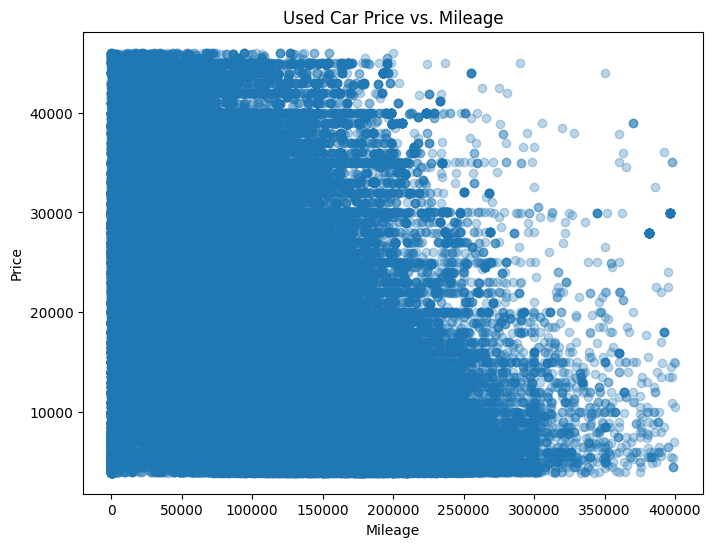

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df['odometer'], df['price'], alpha=0.3)
plt.title("Used Car Price vs. Mileage")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()


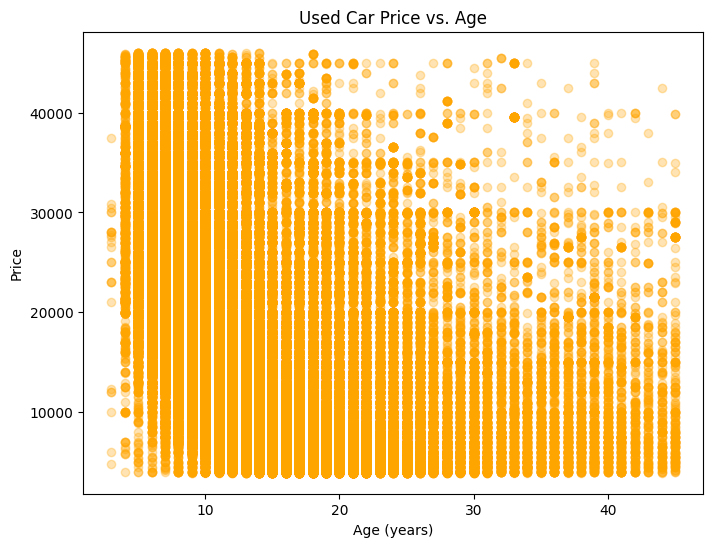

In [29]:
import datetime

current_year = datetime.datetime.now().year   # e.g., 2025
df['Age'] = current_year - df['year']

plt.figure(figsize=(8,6))
plt.scatter(df['Age'], df['price'], alpha=0.3, color='orange')
plt.title("Used Car Price vs. Age")
plt.xlabel("Age (years)")
plt.ylabel("Price")
plt.show()


<Figure size 800x600 with 0 Axes>

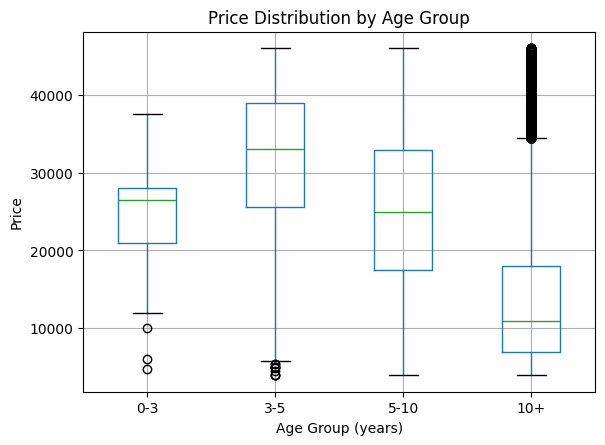

In [31]:
import pandas as pd

df['AgeGroup'] = pd.cut(df['Age'], bins=[0,3,5,10,20], labels=["0-3","3-5","5-10","10+"])

plt.figure(figsize=(8,6))
df.boxplot(column='price', by='AgeGroup')
plt.title("Price Distribution by Age Group")
plt.suptitle("")
plt.xlabel("Age Group (years)")
plt.ylabel("Price")
plt.show()


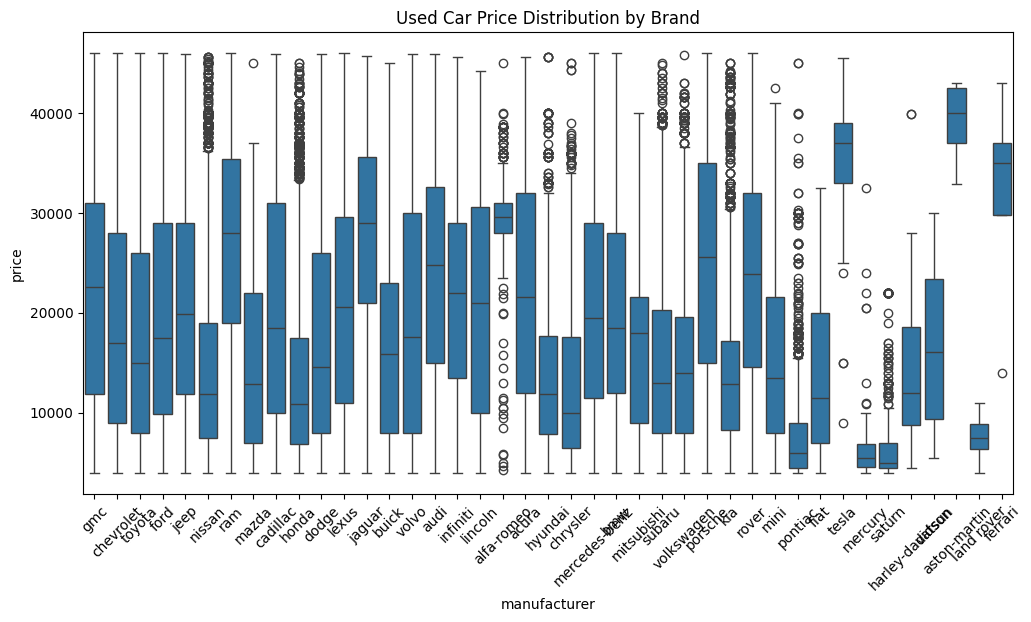

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x="manufacturer", y="price", data=df)
plt.title("Used Car Price Distribution by Brand")
plt.xticks(rotation=45)
plt.show()
